In [3]:
import pandas as pd
import numpy as np
import re
import csv
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter

In [4]:
def getNumber(value):
    # strip of M (in net worth, share price) and convert to integer
    return int(value.replace('M',''))

In [5]:
# define regex expressions to be used in parsing the log files
rx_dict = {
    'round': re.compile(r'== Start of (.*) =='),
    'buytrain': re.compile(r'(?P<company>.*) buys a (?P<train>.*-train) from (?P<source>.*) for'),
    'name_score': re.compile(r'(?P<name_score>Name|Score)'),
    'earnings': re.compile(r'(?P<company>.*) earns (?P<earnings>.*)'),
    'no_earnings': re.compile(r'(?P<company>.*) does not pay a dividend')
}

In [6]:
def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """

    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None

In [7]:
def parse_file(filepath, name):
    """
    Parse text at given filepath

    Parameters
    ----------
    filepath : str
        Filepath for file_object to be parsed

    Returns
    -------
    data : pd.DataFrame
        Parsed data

    """

    data = []  # create an empty list to collect the buy-train data
    data_earnings = [] # same for earnings
    # open the file and read through it line by line
    count = 0
    count_or = 0
    count_earnings = 0
    rnd='no round'
    with open(filepath, 'r') as file_object:
        line = file_object.readline()
        while line:
            # at each line check for a match with a regex
            key, match = _parse_line(line)

            # extract round
            if key == 'round':
                count += 1
                count_earnings += 1
                rnd_raw = match.group(1)
                opr = re.compile(r'Operating Round ')
                if opr.match(rnd_raw):
                    count_or+=1
                rnd = opr.sub('OR', rnd_raw)
                item = [count,count_or,name,None,None,None, rnd]
                
                data.append(item)

            # extract train buying
            if key == 'buytrain':
                count += 1
                company = match.group('company')
                train = match.group('train')
                source = match.group('source')
                item = [count,count_or,name,company,train,source, rnd]
                data.append(item)

            # extract earnings
            if key == 'earnings' or key == 'no_earnings':
                if key == 'earnings':
                    earnings = getNumber(match.group('earnings'))
                else:
                    earnings = 0
                count_earnings +=1
                company = match.group('company')
                item_earnings = [count_earnings,count_or,name,company,earnings, rnd]
                data_earnings.append(item_earnings)
       
            line = file_object.readline()

    df = pd.DataFrame(data, columns = ['Count', 'Count_OR', 'Game', 'Company', 'Train', 'Source', 'Round'])
    dfe = pd.DataFrame(data_earnings, columns = ['Count', 'Count_OR', 'Game', 'Company', 'Earnings', 'Round'])
    return df, dfe

In [8]:
# read files one by one, parse them, concatenate the resulting dataframes

logdir="logfiles"
directory = os.fsencode(logdir)

dflist=[]
dfelist=[]
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    filepath = os.path.join(logdir, filename)
    name = os.path.splitext(filename)[0]
    dff, dfef = parse_file(filepath, name)
    dflist.append(dff)
    dfelist.append(dfef)
df=pd.concat(dflist)   
dfe=pd.concat(dfelist)


In [9]:
df

,Count,Count_OR,Game,Company,Train,Source,Round
0,1,0,R01,None,None,None,initial round
1,2,0,R01,None,None,None,Stock Round 1
2,3,1,R01,None,None,None,OR1.1
3,4,1,R01,M1,2-train,IPO,OR1.1
4,5,1,R01,M3,2-train,IPO,OR1.1
5,6,1,R01,M4,2-train,IPO,OR1.1
6,7,1,R01,M5,2-train,IPO,OR1.1
7,8,1,R01,M6,2-train,IPO,OR1.1
8,9,1,R01,BY,2-train,IPO,OR1.1
9,10,1,R01,BY,2-train,IPO,OR1.1


In [10]:
# create dictionary for trains, for sorting purposes
custom_dict = {'2-train': 0, '2+2-train': 1, '3-train': 2, '3+3-train': 3, '4-train': 4, '4+4-train': 5,
               '5-train': 6, '5+5-train': 7, '6-train': 8, '6+6-train': 9}
custom_dict

{'2-train': 0,
 '2+2-train': 1,
 '3-train': 2,
 '3+3-train': 3,
 '4-train': 4,
 '4+4-train': 5,
 '5-train': 6,
 '5+5-train': 7,
 '6-train': 8,
 '6+6-train': 9}

In [11]:
df['Train'] = pd.Categorical(
    df['Train'], categories=sorted(custom_dict, key=custom_dict.get), ordered=True
)

In [12]:
# let's analyze when trains are bought from IPO
df_ipo = df[df['Source']=='IPO']

In [13]:
df_ipo

,Count,Count_OR,Game,Company,Train,Source,Round
3,4,1,R01,M1,2-train,IPO,OR1.1
4,5,1,R01,M3,2-train,IPO,OR1.1
5,6,1,R01,M4,2-train,IPO,OR1.1
6,7,1,R01,M5,2-train,IPO,OR1.1
7,8,1,R01,M6,2-train,IPO,OR1.1
8,9,1,R01,BY,2-train,IPO,OR1.1
9,10,1,R01,BY,2-train,IPO,OR1.1
12,13,2,R01,M2,2-train,IPO,OR2.1
13,14,2,R01,M4,2-train,IPO,OR2.1
16,17,3,R01,BY,2+2-train,IPO,OR3.1


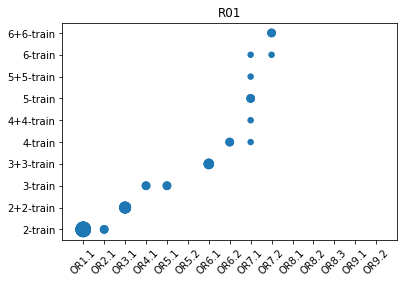

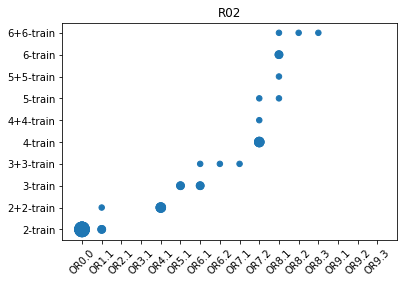

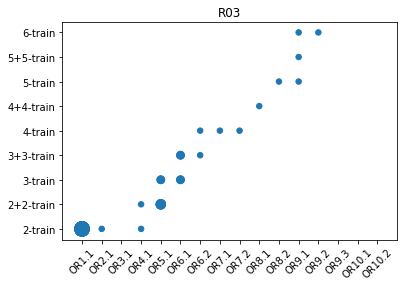

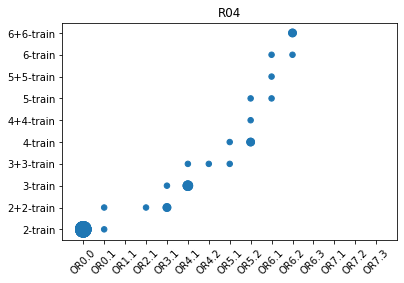

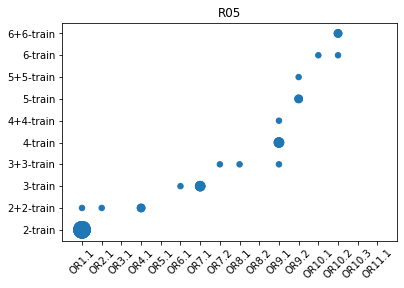

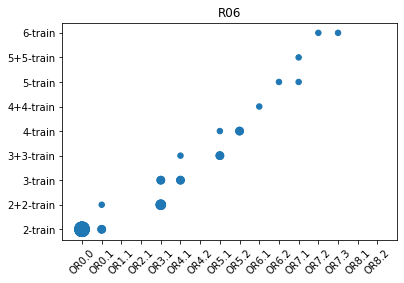

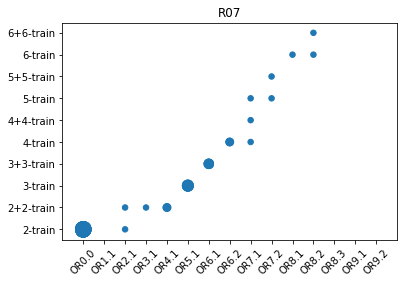

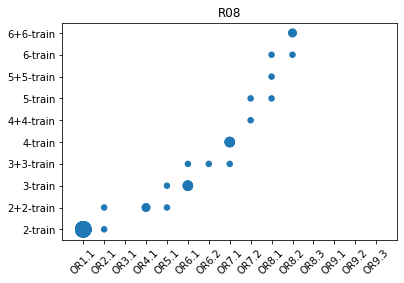

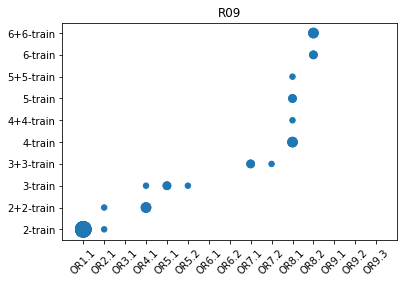

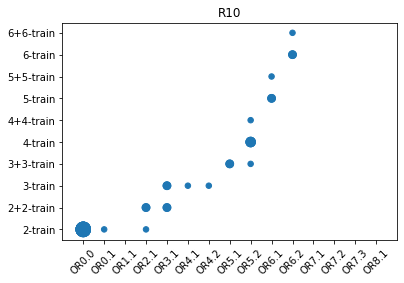

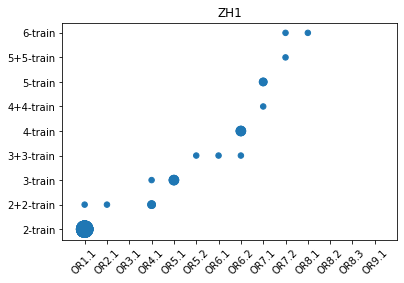

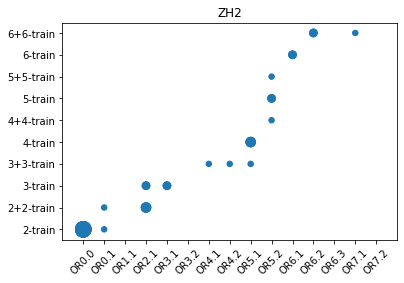

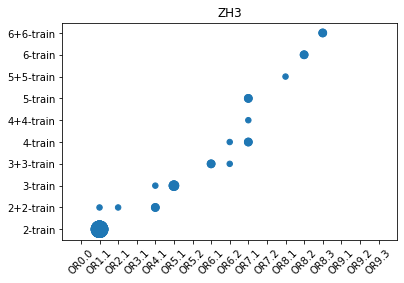

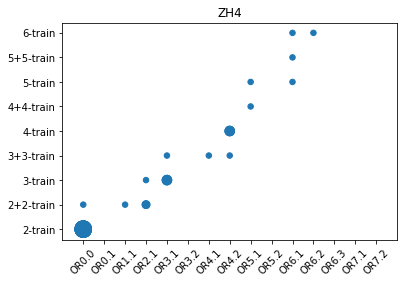

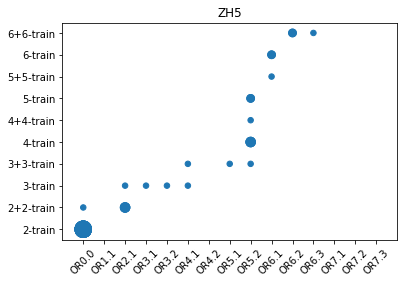

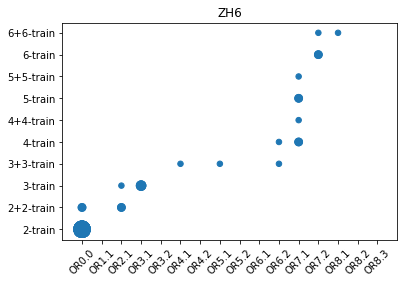

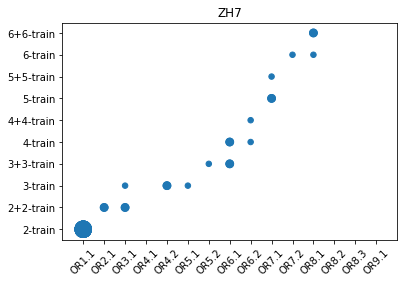

In [14]:
#  for each game, plot trains bought versus operating round

for game in df_ipo['Game'].unique():
    
    opr=re.compile(r'OR')
    select_all = df[df['Game']==game]
    unique=select_all.Round.unique()
    select_or=[el for el in unique if opr.match(el)]
    
    fig, ax = plt.subplots()
    select_ipo = df_ipo[df_ipo['Game']==game]
    x=select_ipo['Count_OR']-1
    y=select_ipo['Train']
    plt.title(game)
    #ax.margins(x=0.4, y=0.1)
    ax.set_xlim(-1,len(select_or))
   
    # count the occurrences of each point
    c = Counter(zip(x,y))
    # create a list of the sizes, here multiplied by 30 for scale
    s = [30*c[(xx,yy)] for xx,yy in zip(x,y)]

    ind = np.arange(len(select_or))
    plt.xticks(ind, select_or,rotation=45)
    plt.scatter(x,y, s=s)


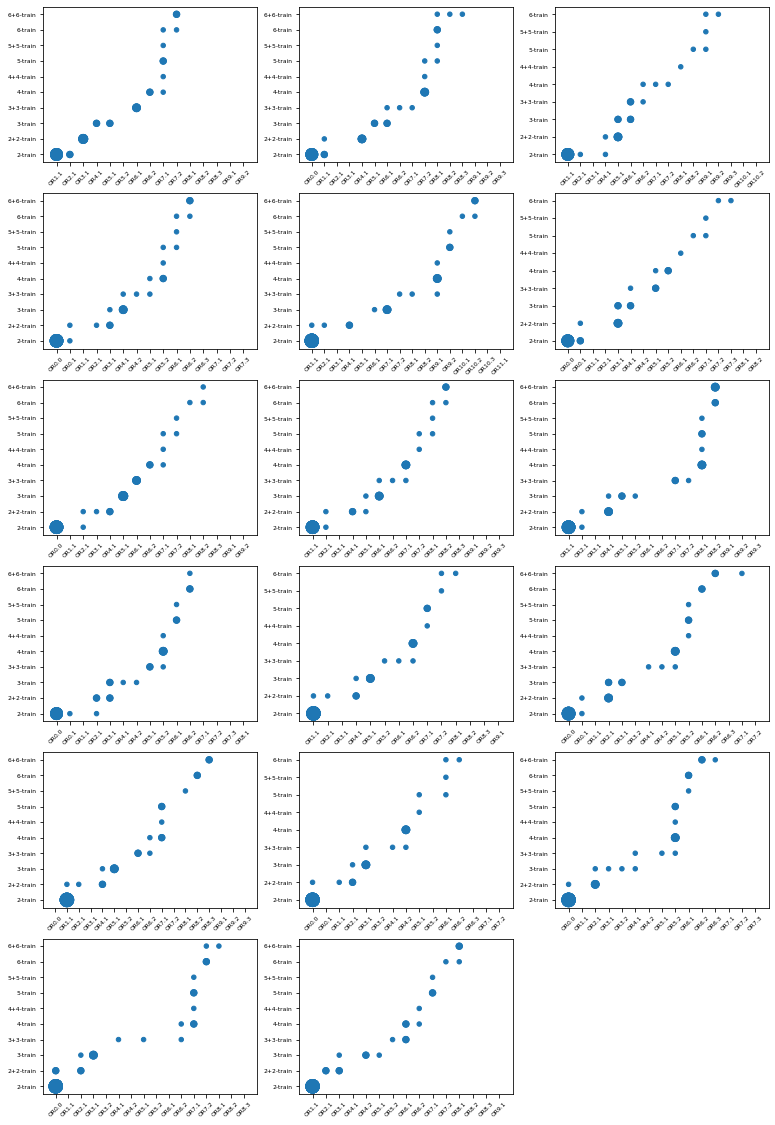

In [15]:
#  for each game, plot trains bought versus operating round

count=0
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(13, 20))
ax[-1, -1].axis('off')
for game in df_ipo['Game'].unique():
    
    
    row = count//3
    column = count%3
    opr=re.compile(r'OR')
    select_all = df[df['Game']==game]
    unique=select_all.Round.unique()
    select_or=[el for el in unique if opr.match(el)]

    select_ipo = df_ipo[df_ipo['Game']==game]
    x=select_ipo['Count_OR']-1
    y=select_ipo['Train']
    #ax[row,column].set_title(game)
    #ax.margins(x=0.4, y=0.1)
    ax[row,column].set_xlim(-1,len(select_or))
   
    # count the occurrences of each point
    c = Counter(zip(x,y))
    # create a list of the sizes, here multiplied by 30 for scale
    s = [20*c[(xx,yy)] for xx,yy in zip(x,y)]

    ind = np.arange(len(select_or))
    ax[row,column].set_xticks(ind) #,rotation=45)
    ax[row,column].set_xticklabels(select_or, rotation=45)
    ax[row,column].tick_params(labelsize=6)
    ax[row,column].scatter(x,y, s=s)
    count+=1


In [16]:
print(df_ipo.groupby(['Train', 'Game']).first().to_string())

                Count  Count_OR Company Source   Round
Train     Game                                        
2-train   R01     4.0       1.0      M1    IPO   OR1.1
          R02     3.0       1.0      M1    IPO   OR0.0
          R03     4.0       1.0      M1    IPO   OR1.1
          R04     3.0       1.0      M1    IPO   OR0.0
          R05     4.0       1.0      M1    IPO   OR1.1
          R06     3.0       1.0      M1    IPO   OR0.0
          R07     3.0       1.0      M1    IPO   OR0.0
          R08     4.0       1.0      M1    IPO   OR1.1
          R09     4.0       1.0      M1    IPO   OR1.1
          R10     3.0       1.0      M1    IPO   OR0.0
          ZH1     4.0       1.0      M1    IPO   OR1.1
          ZH2     3.0       1.0      M1    IPO   OR0.0
          ZH3     6.0       2.0      M1    IPO   OR1.1
          ZH4     3.0       1.0      M1    IPO   OR0.0
          ZH5     3.0       1.0      M1    IPO   OR0.0
          ZH6     3.0       1.0      M1    IPO   OR0.0
          

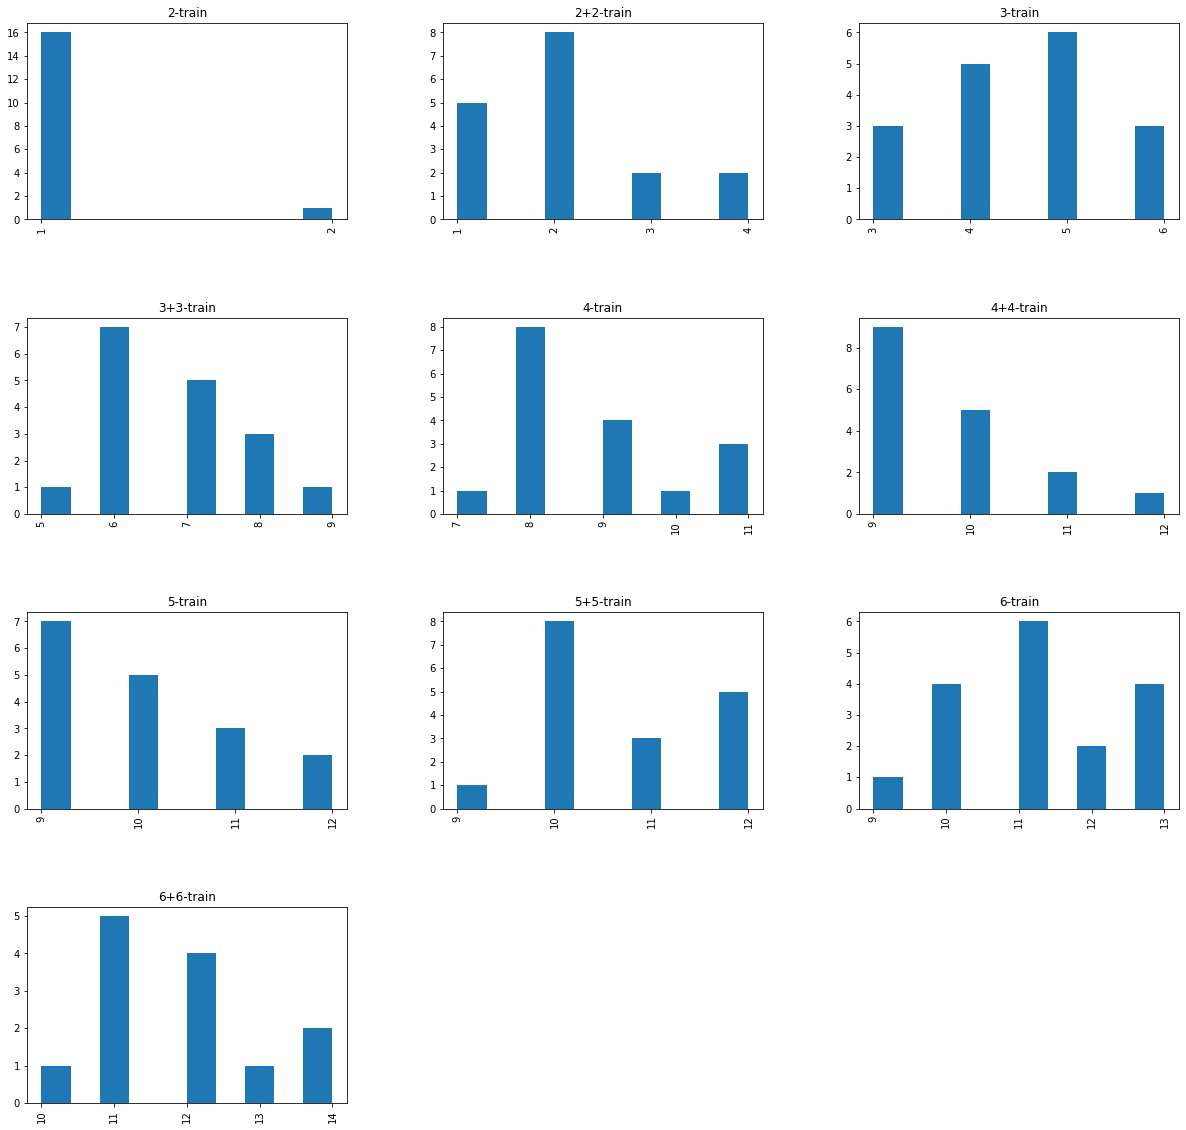

In [17]:
# plot distribution of operating rounds when first train of each type is bought

gr=df_ipo.groupby(['Train', 'Game']).first()

ax=gr.hist(by="Train", column="Count_OR", figsize=(20,20))
for row in ax:
    for col in row:
        col.xaxis.set_major_locator(MaxNLocator(integer=True))

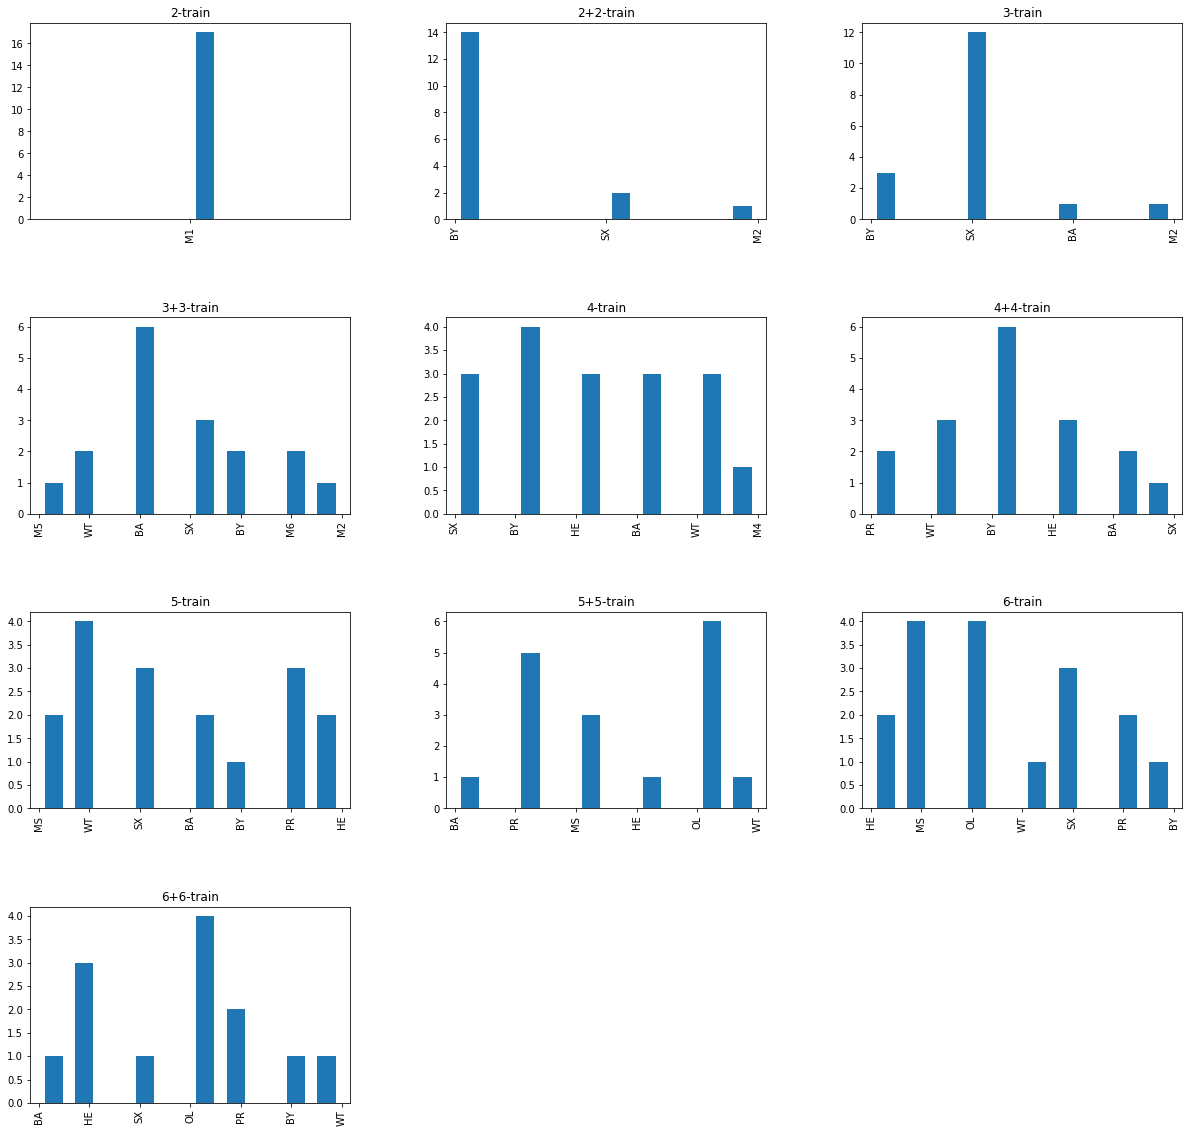

In [18]:
# plot distribution of companies that buy the first train of each type

grc=df_ipo.groupby(['Train', 'Game']).first()

ax=grc.hist(by="Train", column="Company", rwidth=0.6, figsize=(20,20))
#for row in ax:
#    for col in row:
#        col.xaxis.set_major_locator(MaxNLocator(integer=True))

In [19]:
# calculate the number of operating rounds between rusted and rusting train type

gr=df_ipo.groupby(['Game', 'Train'])
#gr.get_group(('R01','2-train'))['Count_OR'].iloc[0]
firsttrainslist = []
for game in df_ipo['Game'].unique():
    firsttrains=[game]
    for train in custom_dict:
        if ((df_ipo['Game']==game) & (df_ipo['Train']==train)).any():
            first = gr.get_group((game,train))['Count_OR'].iloc[0]
            firsttrains.append(first)
    firsttrainslist.append(firsttrains)

columns = [k for k in custom_dict]
columns.insert(0,'Game')
ft = pd.DataFrame(firsttrainslist, columns=columns)
ft['2-4'] = ft.apply(lambda x: x['4-train']- x['2-train'], axis=1)
ft['2+2-4+4'] = ft.apply(lambda x: x['4+4-train']- x['2+2-train'], axis=1)
ft['3-6'] = ft.apply(lambda x: x['6-train']- x['3-train'], axis=1)
ft['3+3-6+6'] = ft.apply(lambda x: x['6+6-train']- x['3+3-train'], axis=1)
ft

,Game,2-train,2+2-train,3-train,3+3-train,4-train,4+4-train,5-train,5+5-train,6-train,6+6-train,2-4,2+2-4+4,3-6,3+3-6+6
0,R01,1,3,4,7,8,9,9,9,9,10.0,7,6,5,3.0
1,R02,1,2,6,7,10,10,10,11,11,11.0,9,8,5,4.0
2,R03,1,4,5,6,7,10,11,12,12,NaN,6,6,7,NaN
3,R04,1,2,5,6,8,9,9,10,10,11.0,7,7,5,5.0
4,R05,1,1,6,8,11,11,12,12,13,14.0,10,10,7,6.0
5,R06,1,2,5,6,8,10,11,12,13,NaN,7,8,8,NaN
6,R07,1,3,6,7,8,9,9,10,11,12.0,7,6,5,5.0
7,R08,1,2,5,6,8,9,9,10,10,11.0,7,7,5,5.0
8,R09,1,2,4,9,11,11,11,11,12,12.0,10,9,8,3.0
9,R10,1,4,5,8,9,9,10,10,11,11.0,8,5,6,3.0


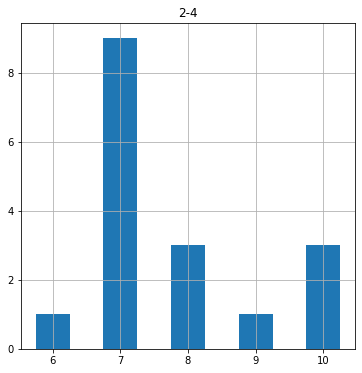

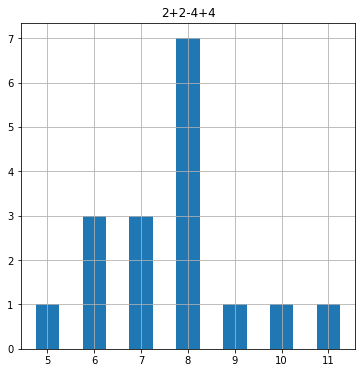

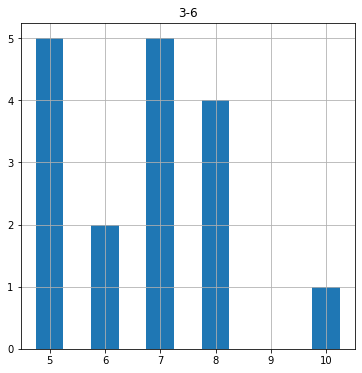

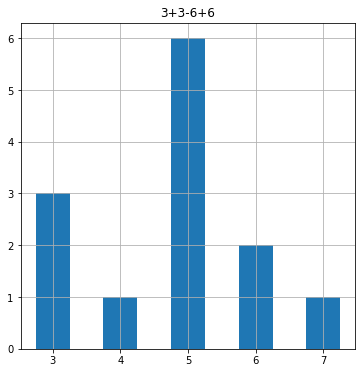

In [20]:
# plot the distribution of number of operating rounds until train type is rusted

for column in ["2-4", "2+2-4+4", "3-6", "3+3-6+6"]:
    bins=np.arange(ft[column].min(), ft[column].max()+2)-0.5
    ax=ft.hist(column=column, figsize=(6,6), bins=bins, rwidth=0.5)
    for row in ax:
        for col in row:
            col.xaxis.set_major_locator(MaxNLocator(integer=True))

In [21]:
def strip(key):
    return key.replace('-train', '')
for key in custom_dict:
    print(key, strip(key))

2-train 2
2+2-train 2+2
3-train 3
3+3-train 3+3
4-train 4
4+4-train 4+4
5-train 5
5+5-train 5+5
6-train 6
6+6-train 6+6


In [22]:
# for each train type, calculate number of operating rounds that the first train of successive train types is bought
# [2, 3, 6, 7, 8, 8, 8, 8, 9] in column '2-train' means:
# first 2+2-train is bought 2 rounds after first 2-train
# first   3-train is bought 3 rounds after first 2-train
# first 3+3-train is bought 6 rounds after first 2-train
# etc.
diflist = []
for game in firsttrainslist:
    diflistgame = [game[0]]
    for first in range(1,len(game)):
        diflistfirst=[]
        for second in range(first+1,len(game)):
            dif=game[second]-game[first]
            diflistfirst.append(dif)
        diflistgame.append(diflistfirst)
    diflist.append(diflistgame)
diflist            

[['R01',
  [2, 3, 6, 7, 8, 8, 8, 8, 9],
  [1, 4, 5, 6, 6, 6, 6, 7],
  [3, 4, 5, 5, 5, 5, 6],
  [1, 2, 2, 2, 2, 3],
  [1, 1, 1, 1, 2],
  [0, 0, 0, 1],
  [0, 0, 1],
  [0, 1],
  [1],
  []],
 ['R02',
  [1, 5, 6, 9, 9, 9, 10, 10, 10],
  [4, 5, 8, 8, 8, 9, 9, 9],
  [1, 4, 4, 4, 5, 5, 5],
  [3, 3, 3, 4, 4, 4],
  [0, 0, 1, 1, 1],
  [0, 1, 1, 1],
  [1, 1, 1],
  [0, 0],
  [0],
  []],
 ['R03',
  [3, 4, 5, 6, 9, 10, 11, 11],
  [1, 2, 3, 6, 7, 8, 8],
  [1, 2, 5, 6, 7, 7],
  [1, 4, 5, 6, 6],
  [3, 4, 5, 5],
  [1, 2, 2],
  [1, 1],
  [0],
  []],
 ['R04',
  [1, 4, 5, 7, 8, 8, 9, 9, 10],
  [3, 4, 6, 7, 7, 8, 8, 9],
  [1, 3, 4, 4, 5, 5, 6],
  [2, 3, 3, 4, 4, 5],
  [1, 1, 2, 2, 3],
  [0, 1, 1, 2],
  [1, 1, 2],
  [0, 1],
  [1],
  []],
 ['R05',
  [0, 5, 7, 10, 10, 11, 11, 12, 13],
  [5, 7, 10, 10, 11, 11, 12, 13],
  [2, 5, 5, 6, 6, 7, 8],
  [3, 3, 4, 4, 5, 6],
  [0, 1, 1, 2, 3],
  [1, 1, 2, 3],
  [0, 1, 2],
  [1, 2],
  [1],
  []],
 ['R06',
  [1, 4, 5, 7, 9, 10, 11, 12],
  [3, 4, 6, 8, 9, 10, 11],
  [1, 3, 5

In [23]:
ft2 = pd.DataFrame(diflist, columns=columns)
ft2

,Game,2-train,2+2-train,3-train,3+3-train,4-train,4+4-train,5-train,5+5-train,6-train,6+6-train
0,R01,"[2, 3, 6, 7, 8, 8, 8, 8, 9]","[1, 4, 5, 6, 6, 6, 6, 7]","[3, 4, 5, 5, 5, 5, 6]","[1, 2, 2, 2, 2, 3]","[1, 1, 1, 1, 2]","[0, 0, 0, 1]","[0, 0, 1]","[0, 1]",[1],[]
1,R02,"[1, 5, 6, 9, 9, 9, 10, 10, 10]","[4, 5, 8, 8, 8, 9, 9, 9]","[1, 4, 4, 4, 5, 5, 5]","[3, 3, 3, 4, 4, 4]","[0, 0, 1, 1, 1]","[0, 1, 1, 1]","[1, 1, 1]","[0, 0]",[0],[]
2,R03,"[3, 4, 5, 6, 9, 10, 11, 11]","[1, 2, 3, 6, 7, 8, 8]","[1, 2, 5, 6, 7, 7]","[1, 4, 5, 6, 6]","[3, 4, 5, 5]","[1, 2, 2]","[1, 1]",[0],[],None
3,R04,"[1, 4, 5, 7, 8, 8, 9, 9, 10]","[3, 4, 6, 7, 7, 8, 8, 9]","[1, 3, 4, 4, 5, 5, 6]","[2, 3, 3, 4, 4, 5]","[1, 1, 2, 2, 3]","[0, 1, 1, 2]","[1, 1, 2]","[0, 1]",[1],[]
4,R05,"[0, 5, 7, 10, 10, 11, 11, 12, 13]","[5, 7, 10, 10, 11, 11, 12, 13]","[2, 5, 5, 6, 6, 7, 8]","[3, 3, 4, 4, 5, 6]","[0, 1, 1, 2, 3]","[1, 1, 2, 3]","[0, 1, 2]","[1, 2]",[1],[]
5,R06,"[1, 4, 5, 7, 9, 10, 11, 12]","[3, 4, 6, 8, 9, 10, 11]","[1, 3, 5, 6, 7, 8]","[2, 4, 5, 6, 7]","[2, 3, 4, 5]","[1, 2, 3]","[1, 2]",[1],[],None
6,R07,"[2, 5, 6, 7, 8, 8, 9, 10, 11]","[3, 4, 5, 6, 6, 7, 8, 9]","[1, 2, 3, 3, 4, 5, 6]","[1, 2, 2, 3, 4, 5]","[1, 1, 2, 3, 4]","[0, 1, 2, 3]","[1, 2, 3]","[1, 2]",[1],[]
7,R08,"[1, 4, 5, 7, 8, 8, 9, 9, 10]","[3, 4, 6, 7, 7, 8, 8, 9]","[1, 3, 4, 4, 5, 5, 6]","[2, 3, 3, 4, 4, 5]","[1, 1, 2, 2, 3]","[0, 1, 1, 2]","[1, 1, 2]","[0, 1]",[1],[]
8,R09,"[1, 3, 8, 10, 10, 10, 10, 11, 11]","[2, 7, 9, 9, 9, 9, 10, 10]","[5, 7, 7, 7, 7, 8, 8]","[2, 2, 2, 2, 3, 3]","[0, 0, 0, 1, 1]","[0, 0, 1, 1]","[0, 1, 1]","[1, 1]",[0],[]
9,R10,"[3, 4, 7, 8, 8, 9, 9, 10, 10]","[1, 4, 5, 5, 6, 6, 7, 7]","[3, 4, 4, 5, 5, 6, 6]","[1, 1, 2, 2, 3, 3]","[0, 1, 1, 2, 2]","[1, 1, 2, 2]","[0, 1, 1]","[1, 1]",[0],[]


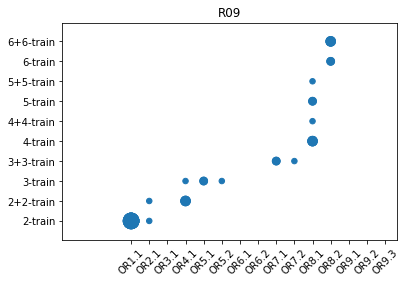

In [24]:

game='R09'
if True:
    
    opr=re.compile(r'OR')
    select_all = df[df['Game']==game]
    unique=select_all.Round.unique()
    select_or=[el for el in unique if opr.match(el)]
    
    fig, ax = plt.subplots()
    select_ipo = df_ipo[df_ipo['Game']==game]
    x=select_ipo['Count_OR']
    y=select_ipo['Train']
    
    # count the occurrences of each point
    c = Counter(zip(x,y))
    # create a list of the sizes, here multiplied by 10 for scale
    s = [30*c[(xx,yy)] for xx,yy in zip(x,y)]
    
    plt.title(game)
    ax.margins(x=0.3, y=0.1)
   
    
    ind = np.arange(len(select_or))
    plt.xticks(ind, select_or,rotation=45)
    plt.scatter(x-1,y, s=s)
    


In [25]:
select_ipo

,Count,Count_OR,Game,Company,Train,Source,Round
3,4,1,R09,M1,2-train,IPO,OR1.1
4,5,1,R09,M3,2-train,IPO,OR1.1
5,6,1,R09,M4,2-train,IPO,OR1.1
6,7,1,R09,M5,2-train,IPO,OR1.1
7,8,1,R09,M6,2-train,IPO,OR1.1
8,9,1,R09,BY,2-train,IPO,OR1.1
9,10,1,R09,BY,2-train,IPO,OR1.1
10,11,1,R09,BY,2-train,IPO,OR1.1
13,14,2,R09,M2,2-train,IPO,OR2.1
14,15,2,R09,BY,2+2-train,IPO,OR2.1


In [26]:
df_ipo


,Count,Count_OR,Game,Company,Train,Source,Round
3,4,1,R01,M1,2-train,IPO,OR1.1
4,5,1,R01,M3,2-train,IPO,OR1.1
5,6,1,R01,M4,2-train,IPO,OR1.1
6,7,1,R01,M5,2-train,IPO,OR1.1
7,8,1,R01,M6,2-train,IPO,OR1.1
8,9,1,R01,BY,2-train,IPO,OR1.1
9,10,1,R01,BY,2-train,IPO,OR1.1
12,13,2,R01,M2,2-train,IPO,OR2.1
13,14,2,R01,M4,2-train,IPO,OR2.1
16,17,3,R01,BY,2+2-train,IPO,OR3.1


In [27]:
df

,Count,Count_OR,Game,Company,Train,Source,Round
0,1,0,R01,None,NaN,None,initial round
1,2,0,R01,None,NaN,None,Stock Round 1
2,3,1,R01,None,NaN,None,OR1.1
3,4,1,R01,M1,2-train,IPO,OR1.1
4,5,1,R01,M3,2-train,IPO,OR1.1
5,6,1,R01,M4,2-train,IPO,OR1.1
6,7,1,R01,M5,2-train,IPO,OR1.1
7,8,1,R01,M6,2-train,IPO,OR1.1
8,9,1,R01,BY,2-train,IPO,OR1.1
9,10,1,R01,BY,2-train,IPO,OR1.1


In [28]:
def parse_status_file(filepath):
    with open(filepath) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        line_count = 0
        player_holdings = []
        player_names = []
        player_worth = []
        player_certs = []
        for row in csv_reader:
            line_count +=1
            if line_count==1:
                company_names = row[8:16]
            elif line_count>=2 and line_count<=5:  # assume 4 players
                player_names.append(row[1])
                player_holdings.append(row[8:16])
                player_worth.append(getNumber(row[18]))
                player_certs.append(row[20])
            elif line_count==9:
                company_shareprices = [getNumber(s.split(sep=" ")[0]) for s in row[8:16]]
            elif line_count==12:
                company_trains = [s.split(sep=" ") for s in row[8:16]]  
    holdings = [pd.DataFrame(list(zip(player_holdings[p], company_names)), columns=['shares', 'company']) for p in range(len(player_holdings))]
    players = pd.DataFrame(list(zip(player_names, holdings, player_worth, player_certs)), columns=['player', 'holdings', 'worth', 'certs'])
    companies = pd.DataFrame(list(zip(company_names,company_shareprices, company_trains)), columns=['company', 'shareprice','trains'])
    return players, companies

In [29]:
logdir="statusfiles"
directory = os.fsencode(logdir)

nameslist = []
playerslist=[]
companieslist= []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    filepath = os.path.join(logdir, filename)
    name = os.path.splitext(filename)[0]
    players, companies = parse_status_file(filepath)
    nameslist.append(name)
    playerslist.append(players)
    companieslist.append(companies)
dfs=pd.DataFrame(list(zip(nameslist,playerslist,companieslist)), columns=['game', 'players', 'companies'])

In [30]:
def getBestPlayerIndex(gamename):
    game = dfs.loc[dfs['game']==gamename]
    players = game.iloc[0]['players']
    bestplayerindex = players['worth']
    return bestplayerindex.idxmax()

In [31]:
def printHoldings(player, companies):
    for holding in player['holdings']:
        print(holding)

In [32]:
def printBestPlayer(game):
    players = game['players']
    gamename = game['game']
    companies  = game['companies']
    bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
    holdings = bestPlayer['holdings']
    print("Game: ", gamename)
    print("shares                        comp  price  trains")
    print("-------------------------------------------------")
    for index, holding in holdings.iterrows():
        shares = holding['shares']
        companyname = holding['company']
        if True: #shares:
            company = companies[companies['company']==companyname].iloc[0]
            print(f"{shares:30} {companyname:4} {company['shareprice']:4}   {company['trains']}")
    print("=================================================")

In [33]:
for index, game in dfs.iterrows():
    printBestPlayer(game)

Game:  R01
shares                        comp  price  trains
-------------------------------------------------
20%{2x10%}                     BY    288   ['6']
                               SX    290   ['4']
80%P{1x20%,4x10%,1x20%P}       BA    150   ['5+5', '6+6']
                               WT    104   ['6+6']
10%{1x10%}                     HE    114   ['6']
                               MS    136   ['5']
100%P{2x20%,4x10%,1x20%P}      OL    150   ['4', '5']
10%{1x10%}                     PR    350   ['4', '4+4']
Game:  R02
shares                        comp  price  trains
-------------------------------------------------
                               BY    382   ['6+6']
60%P{20%Px1,10%x4}             SX    214   ['4', '4']
                               BA    122   ['4', '6+6']
                               WT    168   ['4+4', '5']
80%P{20%Px1,10%x4,20%x1}       HE    106   ['6+6']
                               MS     98   ['6']
40%P{20%Px1,10%x2}             OL     92   ['6

In [74]:
def getPresidencies(game):
    # only for winner
    gamename = game['game']
    players = game['players']
    bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
    holdings = bestPlayer['holdings']
    presidencies = holdings[holdings['shares'].apply(isPresident)]
    return presidencies

def numberOfPresidenciesAll(game):
    # for all players
    gamename = game['game']
    players = game['players']
    npresidencies = [0]*4
    for index, player in players.iterrows():
        holdings = player['holdings']
        presidencies = holdings[holdings['shares'].apply(isPresident)]
        npresidencies[len(presidencies)]+=1
    return npresidencies

def numberOfPresidenciesTwoTrains(game):
    gamename = game['game']
    players = game['players']
    companies = game['companies']
    bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
    holdings = bestPlayer['holdings']
    count=0
    twotraincompanies = []
    for index, holding in holdings.iterrows():
        shares = holding['shares']
        if isPresident(shares):
            companyname = holding['company']
            company = companies[companies['company']==companyname].iloc[0]
            if len(company['trains'])>=2:
                twotraincompanies.append(companyname)
                count+=1   
    return count, twotraincompanies

def numberOfPresidenciesTwoTrainsAll(game):
    gamename = game['game']
    players = game['players']
    companies = game['companies']
    npresidencies = [0]*4
    twotraincompanies = []
    for index, player in players.iterrows():
        holdings = player['holdings']
        count=0
        twotraincompanies_player = []
        for index, holding in holdings.iterrows():
            shares = holding['shares']
            if isPresident(shares):
                companyname = holding['company']
                company = companies[companies['company']==companyname].iloc[0]
                if len(company['trains'])>=2:
                    twotraincompanies_player.append(companyname)
                    count+=1
        npresidencies[count]+=1
        twotraincompanies.append(twotraincompanies_player)
    return npresidencies, twotraincompanies
    

def numberOfPresidenciesPercentage(game, percentage):
    #percentage of the form "80%P"
    # return the number of companies where the president has exactly the give percentage in holdings and is the winner
    gamename = game['game']
    players = game['players']
    companies = game['companies']
    bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
    holdings = bestPlayer['holdings']
    count=0
    for index, holding in holdings.iterrows():
        shares = holding['shares']
        if isPresident(shares) and percentage in shares:
            count+=1   
    return count

def numberOfPresidenciesPercentageAll(game, percentage):
    #percentage of the form "80%P"
    # return the number of companies where the president has exactly the give percentage in holdings
    gamename = game['game']
    players = game['players']
    companies = game['companies']
    count=0
    for index, player in players.iterrows():
        holdings = player['holdings']
        for index, holding in holdings.iterrows():
            shares = holding['shares']
            if isPresident(shares) and percentage in shares:
                count+=1   
    return count

def numberOfPresidenciesTwoTrainsPercentage(game, percentage):
    gamename = game['game']
    players = game['players']
    companies = game['companies']
    bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
    holdings = bestPlayer['holdings']
    count=0
    for index, holding in holdings.iterrows():
        shares = holding['shares']
        if isPresident(shares) and percentage in shares:
            companyname = holding['company']
            company = companies[companies['company']==companyname].iloc[0]
            if len(company['trains'])>=2:
                count+=1   
    return count

def numberOfPresidenciesCompany(game, companyname):
    #percentsage of the form "80%P"
    gamename = game['game']
    players = game['players']
    companies = game['companies']
    bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
    holdings = bestPlayer['holdings']
    count=0
    for index, holding in holdings.iterrows():
        shares = holding['shares']     
        if isPresident(shares) and holding['company']==companyname:
                count+=1   
    return count

def sharePricePresidencies(game):
    gamename = game['game']
    players = game['players']
    companies = game['companies']
    bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
    holdings = bestPlayer['holdings']
    sharePrices = []
    for index, holding in holdings.iterrows():
        shares = holding['shares']     
        if isPresident(shares):
            companyname = holding['company']
            company = companies[companies['company']==companyname].iloc[0]
            sharePrices.append(company['shareprice'])  
    return sharePrices

def winnerIsPresident(game, companyname):
    gamename = game['game']
    players = game['players']
    companies = game['companies']
    bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
    holdings = bestPlayer['holdings']
    comp = holdings[holdings['company']==companyname].iloc[0]
    shares = comp['shares']     
    return isPresident(shares)


def isPresident(shares):
    return 'P' in shares

In [35]:
game=dfs[dfs['game']=='R01'].iloc[0]
gamename = game['game']
players = game['players']
companies = game['companies']
bestPlayer = players.iloc[getBestPlayerIndex(gamename)]
holdings = bestPlayer['holdings']
sel=holdings[holdings['company']=='BA'].iloc[0]
sel['shares']

'80%P{1x20%,4x10%,1x20%P}'

In [78]:
# number of presidencies of the winner
presidencies = [0]*4
presList = []
for index, game in dfs.iterrows():
    pres=getPresidencies(game)
    presList.append(pres)
    n=len(pres)
    presidencies[n]+=1
allPresidencies = pd.concat(presList)
print(presidencies)

[0, 1, 14, 2]


In [97]:
# create dictionary for companies, for sorting purposes
company_dict = {'BY': 0, 'SX': 1, 'BA': 2, 'WT': 3, 'HE': 4, 'MS': 5,
               'OL': 6, 'PR': 7}
company_dict
allPresidencies['company'] = pd.Categorical(
    allPresidencies['company'], categories=sorted(company_dict, key=company_dict.get), ordered=True
)

Text(0.5, 1.0, 'Presidencies of winner')

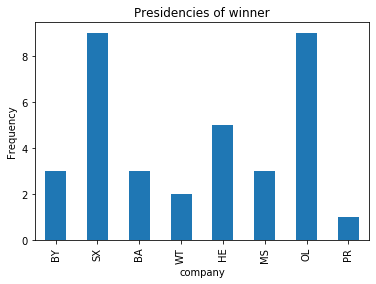

In [98]:
prescount=allPresidencies.groupby('company').count()
pl=prescount.plot.bar()
plt.ylabel('Frequency')
pl.legend_.remove()
plt.title('Presidencies of winner')

{'BY': 0, 'SX': 1, 'BA': 2, 'WT': 3, 'HE': 4, 'MS': 5, 'OL': 6, 'PR': 7}

2    BA
6    OL
1    SX
4    HE
6    OL
1    SX
4    HE
6    OL
7    PR
0    BY
3    WT
1    SX
1    SX
6    OL
0    BY
6    OL
1    SX
3    WT
2    BA
6    OL
4    HE
5    MS
1    SX
5    MS
0    BY
4    HE
2    BA
6    OL
1    SX
5    MS
6    OL
1    SX
4    HE
1    SX
6    OL
Name: company, dtype: object

Text(0, 0.5, 'Frequency')

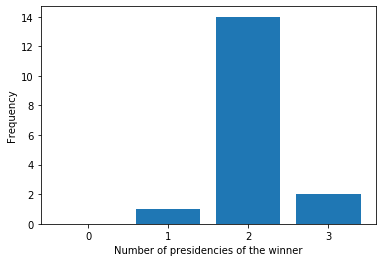

In [37]:
plt.bar(np.arange(4), presidencies)
plt.xticks(np.arange(4))
plt.xlabel("Number of presidencies of the winner")
plt.ylabel("Frequency")

So one game with a winner with just one presidency, two games with a winner with three presidencies.

In [38]:
# number of presidencies of all players
for index, game in dfs.iterrows():
    print(numberOfPresidenciesAll(game))


[0, 0, 4, 0]
[0, 1, 2, 1]
[0, 1, 2, 1]
[0, 0, 4, 0]
[0, 0, 4, 0]
[0, 2, 0, 2]
[0, 0, 4, 0]
[0, 1, 2, 1]
[0, 0, 4, 0]
[0, 0, 4, 0]
[0, 0, 4, 0]
[0, 0, 4, 0]
[0, 0, 4, 0]
[0, 1, 2, 1]
[0, 1, 2, 1]
[0, 0, 4, 0]
[0, 1, 2, 1]


In [39]:
presidencies = [0]*4
for index, game in dfs.iterrows():
    nop,ttc=numberOfPresidenciesTwoTrains(game)
    print(ttc)
    presidencies[nop]+=1
print(presidencies)

['BA', 'OL']
['SX']
[]
['OL', 'PR']
['WT']
['SX']
['SX']
['BY']
['SX', 'WT']
['OL']
['HE', 'MS']
['SX']
['BY']
['BA']
['SX']
['SX']
['SX']
[1, 12, 4, 0]


Text(0, 0.5, 'Frequency')

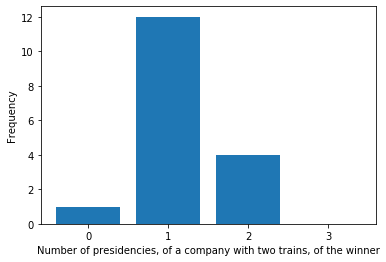

In [40]:
plt.bar(np.arange(4), presidencies)
plt.xticks(np.arange(4))
plt.xlabel("Number of presidencies, of a company with two trains, of the winner")
plt.ylabel("Frequency")

So there was only game where the president had only one-train companies. In 12 games 1 two-train company, in 4 games even 2 two-train companies.

In [41]:

for index, game in dfs.iterrows():
    nop, ttc = numberOfPresidenciesTwoTrainsAll(game)
    print(game['game'], nop, nop[1]+2*nop[2], ttc)


R01 [2, 1, 1, 0] 3 [['BA', 'OL'], [], ['PR'], []]
R02 [0, 4, 0, 0] 4 [['SX'], ['BA'], ['WT'], ['PR']]
R03 [1, 2, 1, 0] 4 [[], ['BY', 'MS'], ['BA'], ['WT']]
R04 [2, 1, 1, 0] 3 [[], [], ['HE'], ['OL', 'PR']]
R05 [1, 3, 0, 0] 3 [['WT'], ['SX'], [], ['MS']]
R06 [1, 2, 1, 0] 4 [[], ['SX'], ['BA'], ['WT', 'PR']]
R07 [2, 2, 0, 0] 2 [['SX'], ['BA'], [], []]
R08 [1, 3, 0, 0] 3 [[], ['BY'], ['PR'], ['HE']]
R09 [1, 2, 1, 0] 4 [['SX', 'WT'], ['HE'], ['MS'], []]
R10 [2, 2, 0, 0] 2 [['OL'], ['SX'], [], []]
ZH1 [1, 2, 1, 0] 4 [['PR'], ['HE', 'MS'], [], ['BY']]
ZH2 [0, 4, 0, 0] 4 [['WT'], ['OL'], ['SX'], ['BA']]
ZH3 [1, 3, 0, 0] 3 [['SX'], ['BY'], [], ['OL']]
ZH4 [2, 1, 1, 0] 3 [['WT', 'PR'], ['BA'], [], []]
ZH5 [1, 2, 1, 0] 4 [['PR'], ['BY', 'WT'], ['SX'], []]
ZH6 [2, 2, 0, 0] 2 [[], ['SX'], ['PR'], []]
ZH7 [2, 1, 1, 0] 3 [[], ['MS', 'PR'], ['SX'], []]


In [42]:
def averageNumPres(presidencies):
    sum=0
    count=0
    for index in range(len(presidencies)):
        sum += index*presidencies[index]
        count+= presidencies[index]
    return sum*1.0/count

In [43]:
#allPercentages = ['100%P', '90%P', '80%P', '70%P', '60%P', '50%P', '40%P']
allPercentages = ['100%P', '95%P', '90%P', '85%P', '80%P', '75%P', '70%P', '65%P', '60%P', '55%P', '50%P', '45%P', '40%P']
averageNum = []
for percentage in allPercentages:
    presidencies = [0]*4
    for index, game in dfs.iterrows():
        n=numberOfPresidenciesPercentage(game, percentage)
        presidencies[n]+=1
    avn = averageNumPres(presidencies)
    averageNum.append(avn)
    print(percentage, presidencies, avn)

100%P [3, 13, 1, 0] 0.8823529411764706
95%P [17, 0, 0, 0] 0.0
90%P [9, 7, 1, 0] 0.5294117647058824
85%P [17, 0, 0, 0] 0.0
80%P [11, 6, 0, 0] 0.35294117647058826
75%P [17, 0, 0, 0] 0.0
70%P [17, 0, 0, 0] 0.0
65%P [17, 0, 0, 0] 0.0
60%P [15, 2, 0, 0] 0.11764705882352941
55%P [17, 0, 0, 0] 0.0
50%P [16, 1, 0, 0] 0.058823529411764705
45%P [17, 0, 0, 0] 0.0
40%P [15, 2, 0, 0] 0.11764705882352941


Text(0, 0.5, 'Average number of presidencies')

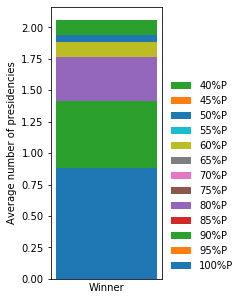

In [44]:
x = [1]
barWidth=0.1

prev =[0]
value = [averageNum[0]]
plt.figure(figsize=(2,5))
plt.bar(x,value,width=barWidth)

for index in range(len(allPercentages)-1):
    prev=np.add(prev,value).tolist()
    value = [averageNum[index+1]]
    plt.bar(x,value,bottom=prev,width=barWidth)
plt.legend(allPercentages, labelspacing=-2.5,  bbox_to_anchor=(1, 0.1), frameon=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.xlabel("Winner")
plt.ylabel("Average number of presidencies")

In [45]:
averageNum = []
for percentage in allPercentages:
    presidencies = [0]*9
    for index, game in dfs.iterrows():
        n=numberOfPresidenciesPercentageAll(game, percentage)
        presidencies[n]+=1
    avn = averageNumPres(presidencies)
    averageNum.append(avn)
    print(percentage, presidencies, avn)

100%P [1, 1, 3, 2, 3, 5, 2, 0, 0] 3.6470588235294117
95%P [16, 1, 0, 0, 0, 0, 0, 0, 0] 0.058823529411764705
90%P [2, 9, 4, 1, 0, 1, 0, 0, 0] 1.4705882352941178
85%P [16, 1, 0, 0, 0, 0, 0, 0, 0] 0.058823529411764705
80%P [4, 7, 5, 1, 0, 0, 0, 0, 0] 1.1764705882352942
75%P [17, 0, 0, 0, 0, 0, 0, 0, 0] 0.0
70%P [15, 2, 0, 0, 0, 0, 0, 0, 0] 0.11764705882352941
65%P [15, 2, 0, 0, 0, 0, 0, 0, 0] 0.11764705882352941
60%P [15, 1, 1, 0, 0, 0, 0, 0, 0] 0.17647058823529413
55%P [17, 0, 0, 0, 0, 0, 0, 0, 0] 0.0
50%P [10, 6, 1, 0, 0, 0, 0, 0, 0] 0.47058823529411764
45%P [16, 1, 0, 0, 0, 0, 0, 0, 0] 0.058823529411764705
40%P [9, 6, 1, 1, 0, 0, 0, 0, 0] 0.6470588235294118


Text(0, 0.5, 'Average number of presidencies')

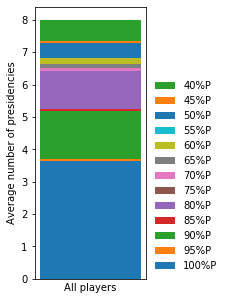

In [46]:
x = [1]
barWidth=0.1

prev =[0]
value = [averageNum[0]]
plt.figure(figsize=(2,5))
plt.bar(x,value,width=barWidth)

for index in range(len(allPercentages)-1):
    prev=np.add(prev,value).tolist()
    value = [averageNum[index+1]]
    plt.bar(x,value,bottom=prev,width=barWidth)
plt.legend(allPercentages, labelspacing=-2.5,  bbox_to_anchor=(1, 0.1), frameon=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.xlabel("All players")
plt.ylabel("Average number of presidencies")


In [47]:
for percentage in allPercentages:
    presidencies = [0]*4
    for index, game in dfs.iterrows():
        n=numberOfPresidenciesTwoTrainsPercentage(game, percentage)
        presidencies[n]+=1
    print(percentage, presidencies)

100%P [6, 11, 0, 0]
95%P [17, 0, 0, 0]
90%P [14, 2, 1, 0]
85%P [17, 0, 0, 0]
80%P [15, 2, 0, 0]
75%P [17, 0, 0, 0]
70%P [17, 0, 0, 0]
65%P [17, 0, 0, 0]
60%P [16, 1, 0, 0]
55%P [17, 0, 0, 0]
50%P [16, 1, 0, 0]
45%P [17, 0, 0, 0]
40%P [16, 1, 0, 0]


In [48]:
for company in ['BY', 'SX', 'BA', 'WT', 'HE', 'MS', 'OL', 'PR']:
    presidencies = [0]*4
    for index, game in dfs.iterrows():
        n=numberOfPresidenciesCompany(game, company)
        presidencies[n]+=1
    print(company, presidencies)

BY [14, 3, 0, 0]
SX [8, 9, 0, 0]
BA [14, 3, 0, 0]
WT [15, 2, 0, 0]
HE [12, 5, 0, 0]
MS [14, 3, 0, 0]
OL [8, 9, 0, 0]
PR [16, 1, 0, 0]


In [49]:
lst = []
for index, game in dfs.iterrows():
    spp = sharePricePresidencies(game)
    gamename=game['game']
    print(gamename , spp)
    for price in spp:
        lst.append([gamename,price])

R01 [150, 150]
R02 [214, 106, 92]
R03 [318, 120]
R04 [92, 320]
R05 [418, 104]
R06 [262]
R07 [286, 88]
R08 [384, 102]
R09 [316, 102]
R10 [138, 122]
ZH1 [186, 104]
ZH2 [316, 94]
ZH3 [384, 112]
ZH4 [234, 102]
ZH5 [348, 92, 96]
ZH6 [382, 96]
ZH7 [348, 108]


In [50]:
lst

[['R01', 150],
 ['R01', 150],
 ['R02', 214],
 ['R02', 106],
 ['R02', 92],
 ['R03', 318],
 ['R03', 120],
 ['R04', 92],
 ['R04', 320],
 ['R05', 418],
 ['R05', 104],
 ['R06', 262],
 ['R07', 286],
 ['R07', 88],
 ['R08', 384],
 ['R08', 102],
 ['R09', 316],
 ['R09', 102],
 ['R10', 138],
 ['R10', 122],
 ['ZH1', 186],
 ['ZH1', 104],
 ['ZH2', 316],
 ['ZH2', 94],
 ['ZH3', 384],
 ['ZH3', 112],
 ['ZH4', 234],
 ['ZH4', 102],
 ['ZH5', 348],
 ['ZH5', 92],
 ['ZH5', 96],
 ['ZH6', 382],
 ['ZH6', 96],
 ['ZH7', 348],
 ['ZH7', 108]]

In [51]:
dfl=pd.DataFrame(lst, columns=['game', 'shareprice'])

In [52]:
dfl


,game,shareprice
0,R01,150
1,R01,150
2,R02,214
3,R02,106
4,R02,92
5,R03,318
6,R03,120
7,R04,92
8,R04,320
9,R05,418


In [53]:
def wip(row, game):
    return winnerIsPresident(game, row['company'])


gms = pd.DataFrame()
for index, game in dfs.iterrows():
    gamename=game['game']
    comp=game.companies.copy()
    comp['game']=gamename
    comp['winnerIsPresident']=comp.apply(wip, axis=1, game=game)
    gms=gms.append(comp)



In [54]:
gms


,company,shareprice,trains,game,winnerIsPresident
0,BY,288,[6],R01,False
1,SX,290,[4],R01,False
2,BA,150,"[5+5, 6+6]",R01,True
3,WT,104,[6+6],R01,False
4,HE,114,[6],R01,False
5,MS,136,[5],R01,False
6,OL,150,"[4, 5]",R01,True
7,PR,350,"[4, 4+4]",R01,False
0,BY,382,[6+6],R02,False
1,SX,214,"[4, 4]",R02,True


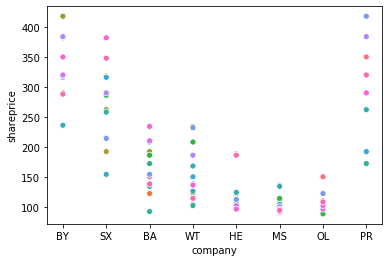

In [55]:
pl=sns.scatterplot(gms.company, gms.shareprice, hue=gms.game)
pl.legend_.remove()

In 4 of the 17 games, the winner has no presidency in one of the top three companies (PR, BY, SX).
In 2 of them, 3+3-trains were in the game and in the companies belonging to winner (4 of 17 have 3+3).


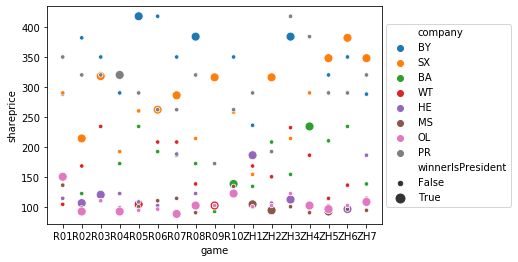

In [56]:
pl=sns.scatterplot(gms.game, gms.shareprice, hue=gms.company, size=gms.winnerIsPresident, sizes=[20, 80])
pl.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), ncol=1)

In [57]:
early = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'BY', 'SX']
majors = ['BY', 'SX', 'BA', 'WT', 'HE', 'MS', 'OL', 'PR']
minors = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']

In [58]:
def isEarly(row):
    return row['Company'] in early

def isMajor(row):
    return row['Company'] in majors

def isMinor(row):
    return row['Company'] in minors

In [59]:
r1=dfe[dfe['Game']=='ZH7']
r1early = r1[r1.apply(isEarly, axis=1)]
r1major = r1[r1.apply(isMajor, axis=1)]

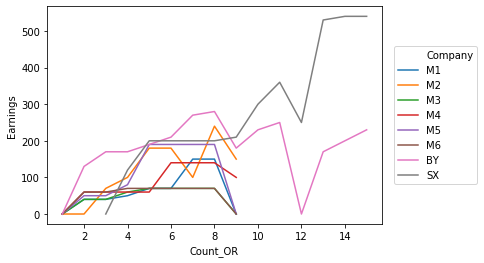

In [60]:
ple=sns.lineplot(r1early.Count_OR, r1early.Earnings, hue=r1early.Company)
ple.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

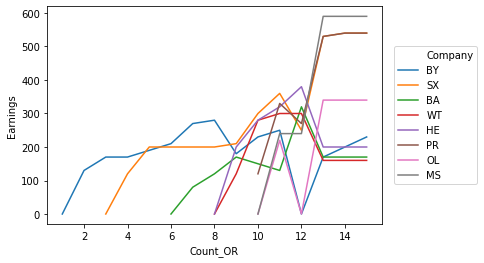

In [61]:
ple=sns.lineplot(r1major.Count_OR, r1major.Earnings, hue=r1major.Company)
ple.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

C:\Users\peter\Anaconda3\envs\str1835\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
C:\Users\peter\Anaconda3\envs\str1835\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
C:\Users\peter\Anaconda3\envs\str1835\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

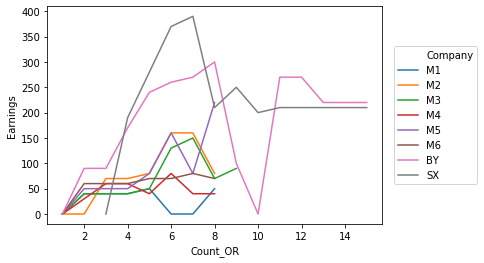

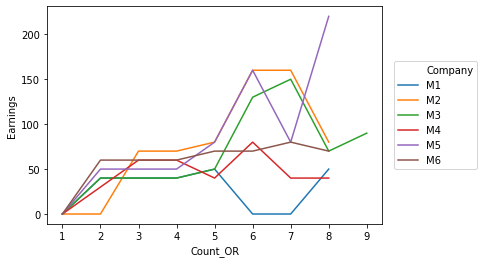

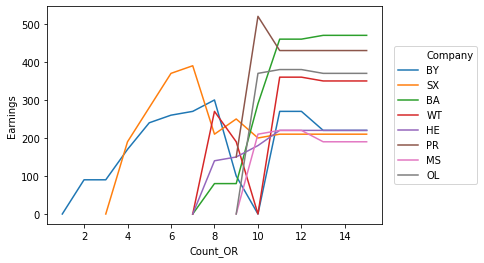

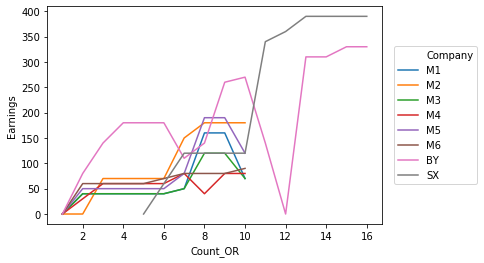

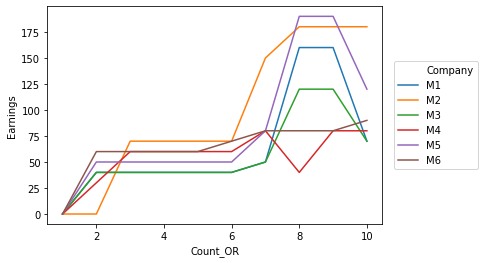

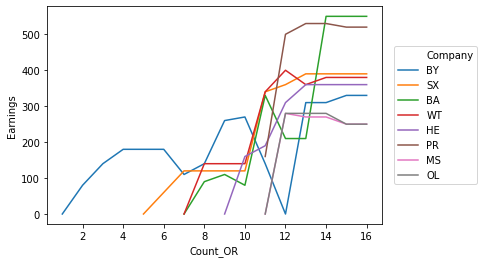

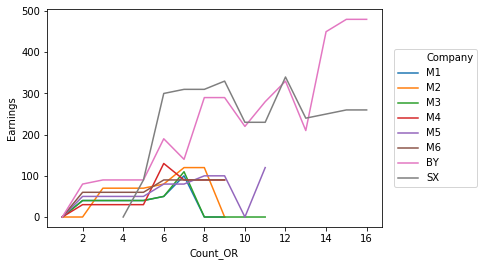

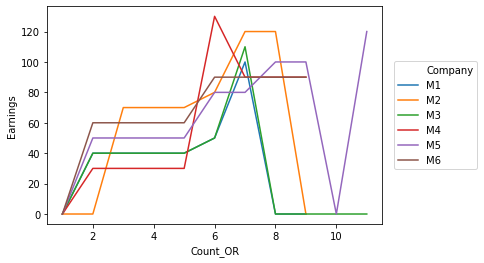

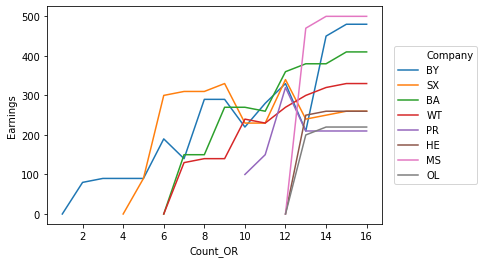

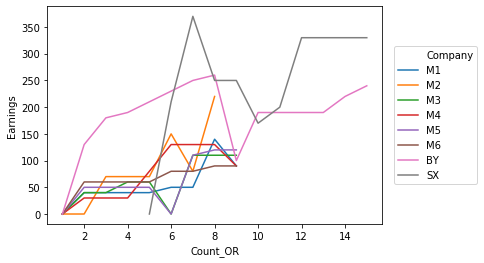

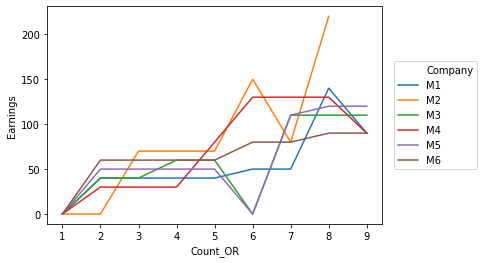

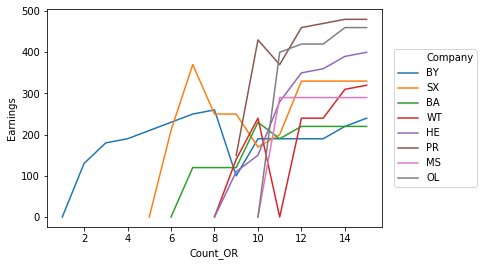

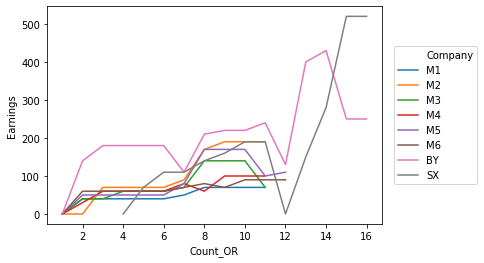

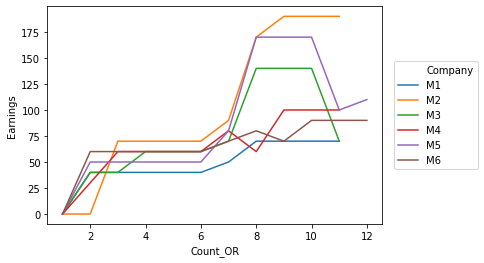

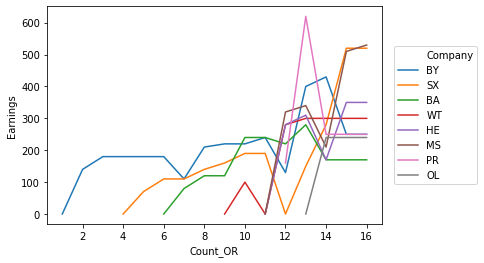

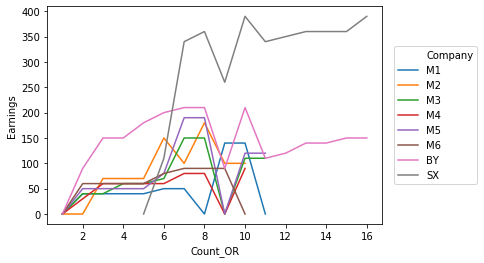

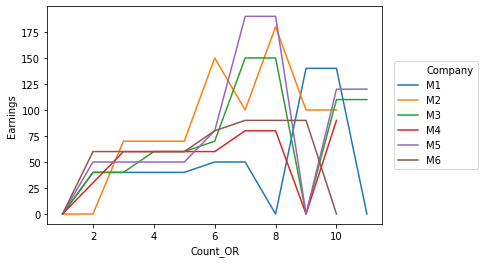

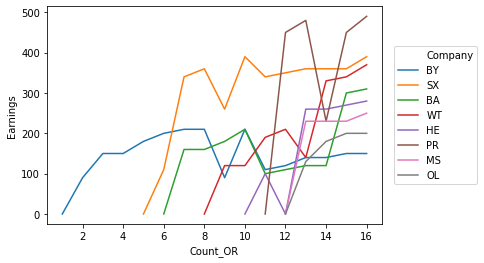

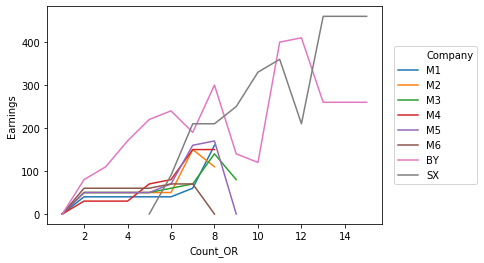

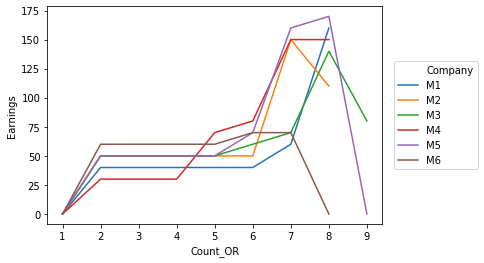

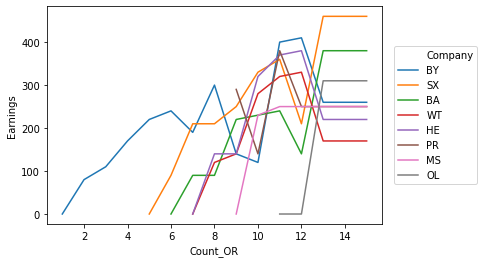

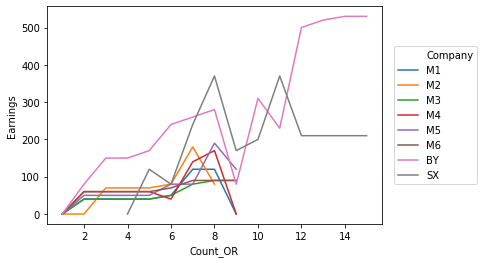

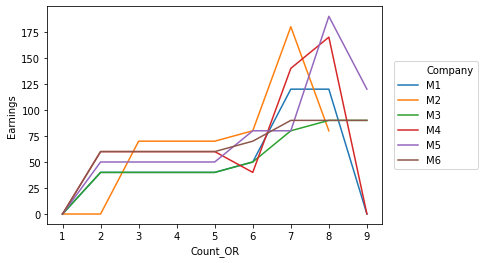

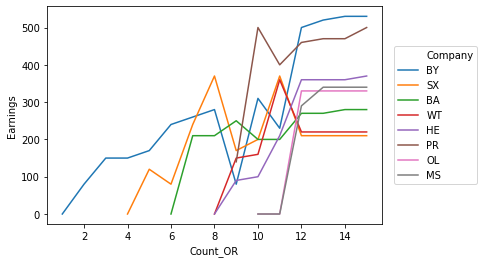

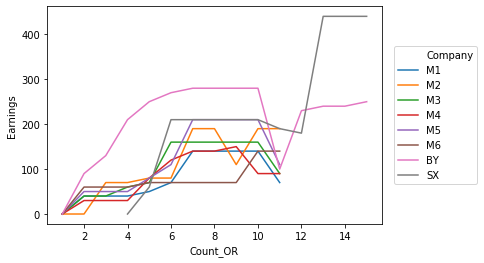

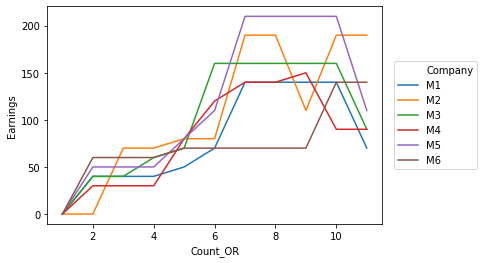

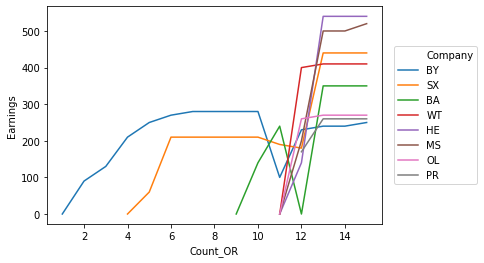

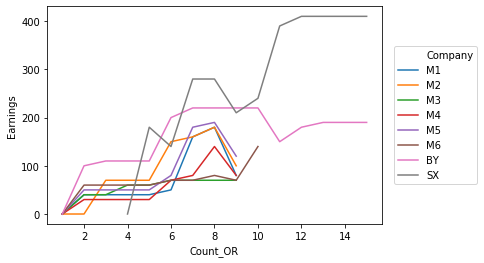

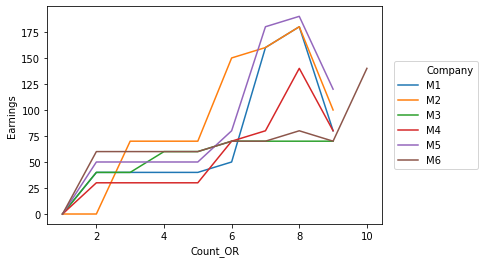

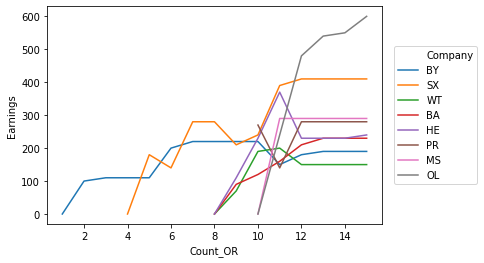

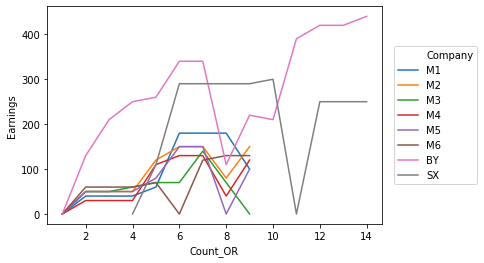

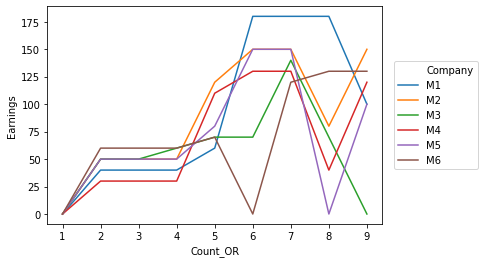

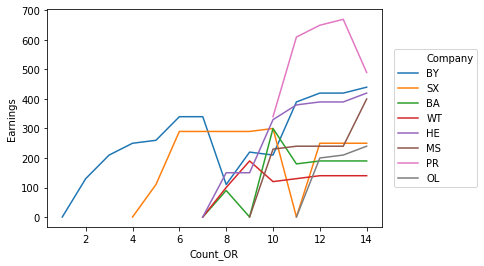

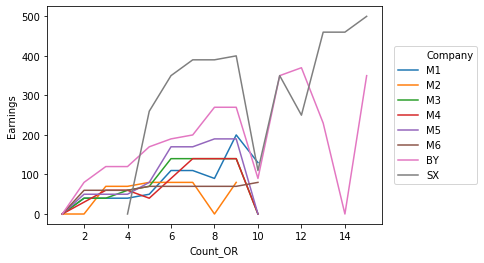

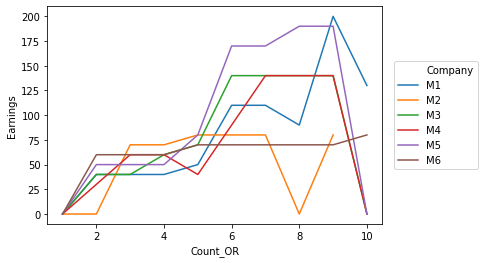

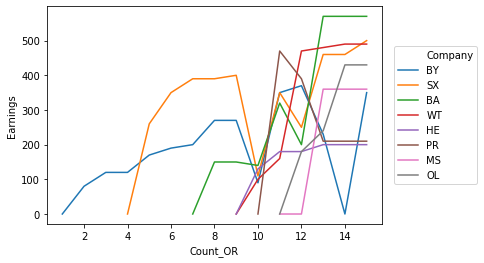

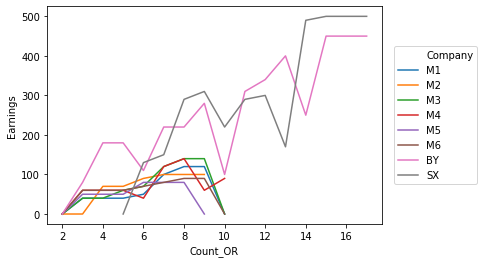

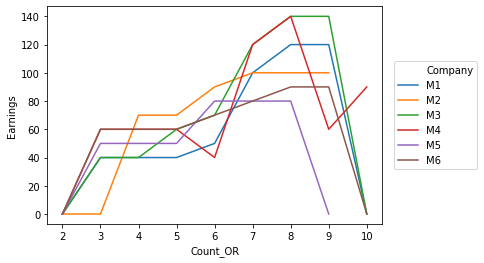

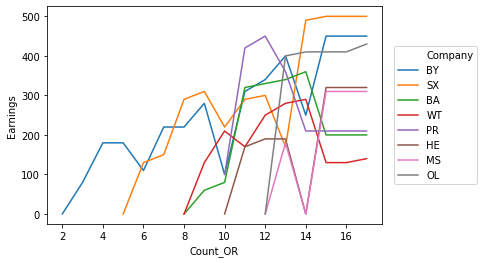

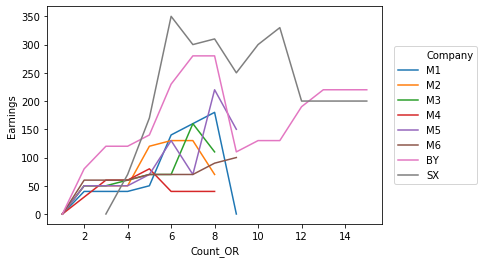

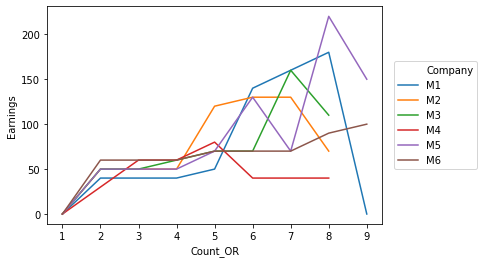

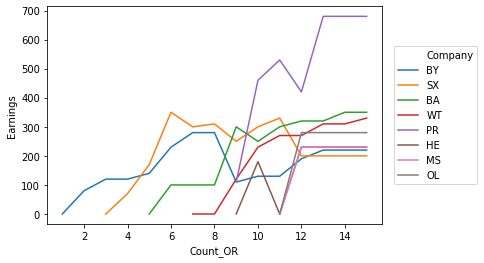

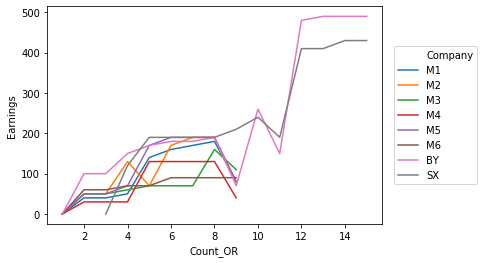

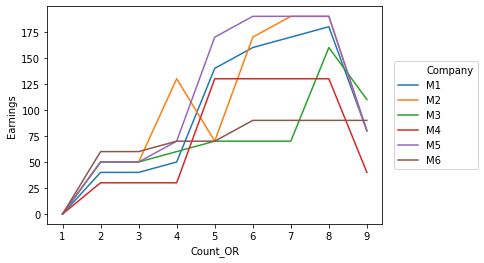

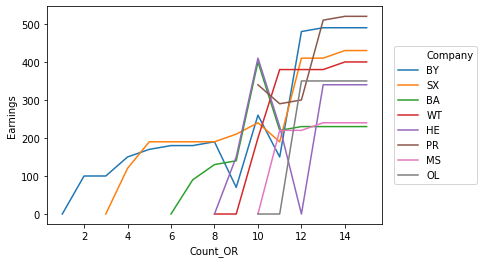

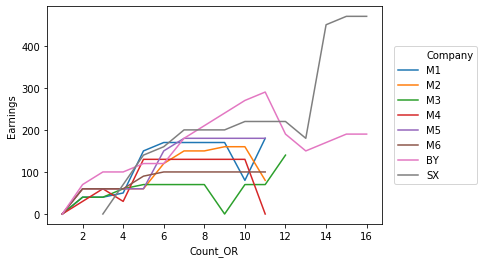

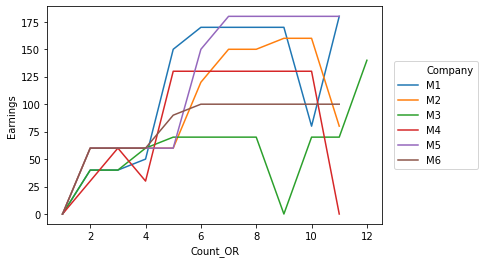

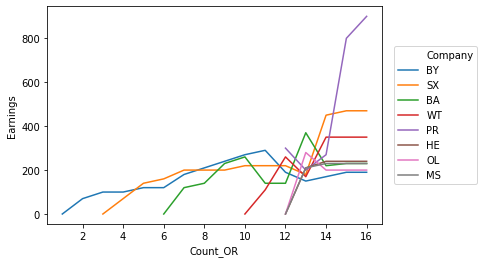

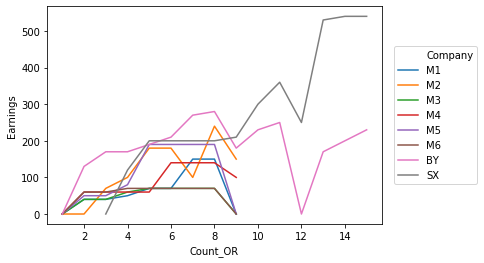

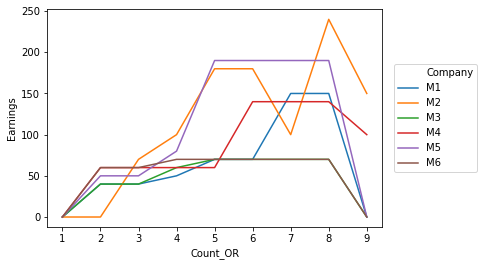

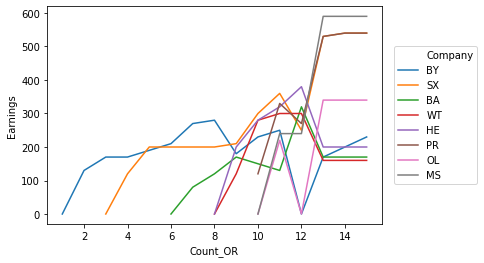

In [62]:
for game in dfe['Game'].unique():
    rg=dfe[dfe['Game']==game]
    rgearly = rg[rg.apply(isEarly, axis=1)]
    rgmajor = rg[rg.apply(isMajor, axis=1)]
    rgminor = rg[rg.apply(isMinor, axis=1)]

    plt.figure()
    ple=sns.lineplot(rgearly.Count_OR, rgearly.Earnings, hue=rgearly.Company)
    ple.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
    plt.figure()
    plmi=sns.lineplot(rgminor.Count_OR, rgminor.Earnings, hue=rgminor.Company)
    plmi.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
    plt.figure()
    plma=sns.lineplot(rgmajor.Count_OR, rgmajor.Earnings, hue=rgmajor.Company)
    plma.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)


In [122]:
ds=dfe.groupby(['Company','Game'])['Earnings'].sum()
ds['M2']

Game
R01     620
R02     970
R03     530
R04     660
R05    1110
R06     840
R07     510
R08     550
R09    1170
R10     800
ZH1     800
ZH2     460
ZH3     530
ZH4     600
ZH5     930
ZH6    1060
ZH7    1020
Name: Earnings, dtype: int64

In [119]:
dsa=dfe.groupby(['Company'])['Earnings'].sum()/17
dsa

Company
BA    2035.882353
BY    3077.647059
HE    1591.764706
M1     620.000000
M2     774.117647
M3     614.705882
M4     613.529412
M5     824.117647
M6     611.764706
MS    1384.705882
OL    1317.058824
PR    2232.352941
SX    3078.235294
WT    1769.411765
Name: Earnings, dtype: float64

In [63]:
lastor=df.groupby('Game').last()
lastor

,Count,Count_OR,Company,Train,Source,Round
Game,,,,,,
R01,70,15,WT,6+6-train,IPO,OR9.2
R02,73,16,BA,6+6-train,IPO,OR9.3
R03,71,16,BY,6-train,IPO,OR10.2
R04,64,15,WT,6+6-train,IPO,OR7.3
R05,75,16,MS,6+6-train,IPO,OR11.1
R06,78,16,BA,3+3-train,OL,OR8.2
R07,68,15,OL,6+6-train,IPO,OR9.2
R08,69,15,MS,6+6-train,IPO,OR9.3
R09,75,15,MS,6+6-train,PR,OR9.3


In [64]:
lastor_count = lastor.groupby('Round').count()
lastor_count

,Count,Count_OR,Company,Train,Source
Round,,,,,
OR10.2,1,1,1,1,1
OR11.1,1,1,1,1,1
OR7.2,2,2,2,2,2
OR7.3,2,2,2,2,2
OR8.1,1,1,1,1,1
OR8.2,1,1,1,1,1
OR8.3,1,1,1,1,1
OR9.1,2,2,2,2,2
OR9.2,2,2,2,2,2


In [65]:
lastor_count_sorted = pd.concat([lastor_count.tail(8), lastor_count.head(2)])
lastor_count_sorted

,Count,Count_OR,Company,Train,Source
Round,,,,,
OR7.2,2,2,2,2,2
OR7.3,2,2,2,2,2
OR8.1,1,1,1,1,1
OR8.2,1,1,1,1,1
OR8.3,1,1,1,1,1
OR9.1,2,2,2,2,2
OR9.2,2,2,2,2,2
OR9.3,4,4,4,4,4
OR10.2,1,1,1,1,1


[[<matplotlib.axis.YTick at 0x1f876b22e80>,
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Last operating round')]

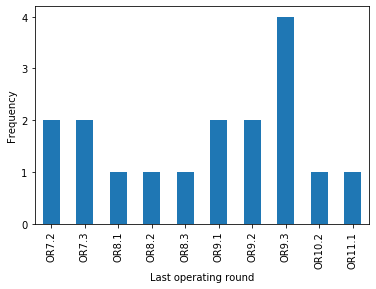

In [66]:
ax=lastor_count_sorted.plot.bar(y='Count', legend=False)
ax.set(xlabel='Last operating round', ylabel='Frequency', yticks=np.arange(5))

In [67]:
lastcount_or_count = lastor.groupby('Count_OR').count()
lastcount_or_count

,Count,Company,Train,Source,Round
Count_OR,,,,,
14,1,1,1,1,1
15,10,10,10,10,10
16,5,5,5,5,5
17,1,1,1,1,1


[[<matplotlib.axis.YTick at 0x1f876ca9cf8>,
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Last operating round')]

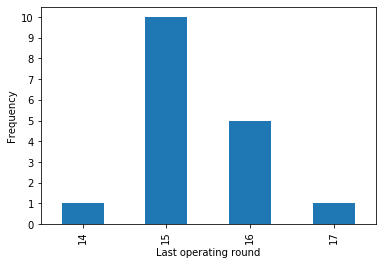

In [68]:
ax=lastcount_or_count.plot.bar(y='Count', legend=False)
ax.set(xlabel='Last operating round', ylabel='Frequency', yticks=np.arange(11))